In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seed = 42

In [3]:
from datasets import load_dataset

dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

In [4]:
train = dataset['train']

In [5]:
train_df = pd.DataFrame(train)

In [6]:
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]

In [7]:
train_df['qtype'].value_counts()

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
Name: count, dtype: int64

In [8]:
train_df.shape

(16283, 3)

In [9]:
train_df, test_df = train_test_split(train_df ,test_size = 0.3, random_state = seed)

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [11]:
# Fit and transform the labels
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])

In [12]:
# Fit and transform the labels
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])

In [13]:
# Create a mapping of the original labels to the encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [14]:
# Print the mapping
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [15]:
from transformers import BertTokenizer, BertForSequenceClassification

In [20]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=13)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
# Define a function to tokenize texts in batches
def tokenize_texts(texts, batch_size=8):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        tokenized_texts.append(inputs)
    return tokenized_texts

In [23]:
def get_predictions(tokenized_texts):
    predictions = []
    with torch.no_grad():
        for batch in tokenized_texts:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

In [24]:
# Tokenize the texts in your dataset
texts = train_df['Question'].tolist()
tokenized_texts = tokenize_texts(texts)

In [25]:
# Get the predictions
predicted_labels = get_predictions(tokenized_texts)

In [26]:
# Add the predictions to the dataframe
train_df['predicted_label'] = predicted_labels

In [29]:
# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
true_labels = train_df['labels'].tolist()
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.1488857694332339
F1 Score: 0.039634977193443305
Precision: 0.11400196062826067
Recall: 0.1488857694332339


In [31]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

<Figure size 3000x3000 with 0 Axes>

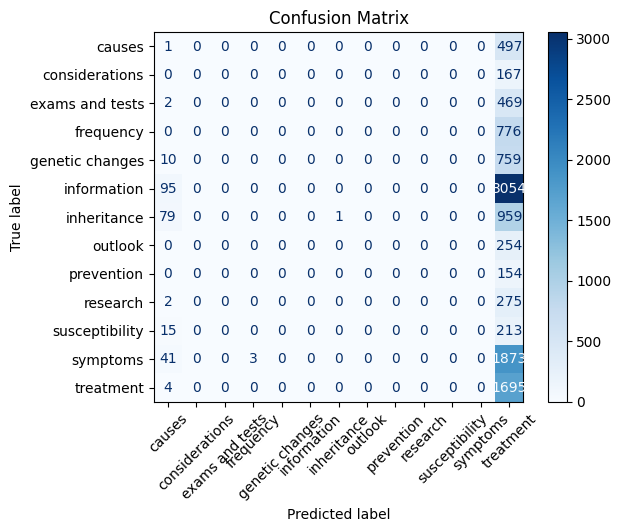

In [32]:
# Display the confusion matrix
plt.figure(figsize=(30,30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Tokenize the texts in the test dataset
test_texts = test_df['Question'].tolist()
test_tokenized_texts = tokenize_texts(test_texts)

In [34]:
# Get the predictions for the test set
test_predicted_labels = get_predictions(test_tokenized_texts)

In [35]:
# Encode labels
label_encoder = LabelEncoder()
test_df['labels'] = label_encoder.fit_transform(test_df['qtype'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [36]:
# Calculate evaluation metrics for the test set
test_true_labels = test_df['labels'].tolist()
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)
test_f1 = f1_score(test_true_labels, test_predicted_labels, average='weighted')
test_precision = precision_score(test_true_labels, test_predicted_labels, average='weighted')
test_recall = recall_score(test_true_labels, test_predicted_labels, average='weighted')

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print("Test Set Evaluation Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")

Test Set Evaluation Metrics:
Accuracy: 0.15168884339815764
F1 Score: 0.040753863910624154
Precision: 0.023539016425403323
Recall: 0.15168884339815764


<Figure size 3000x3000 with 0 Axes>

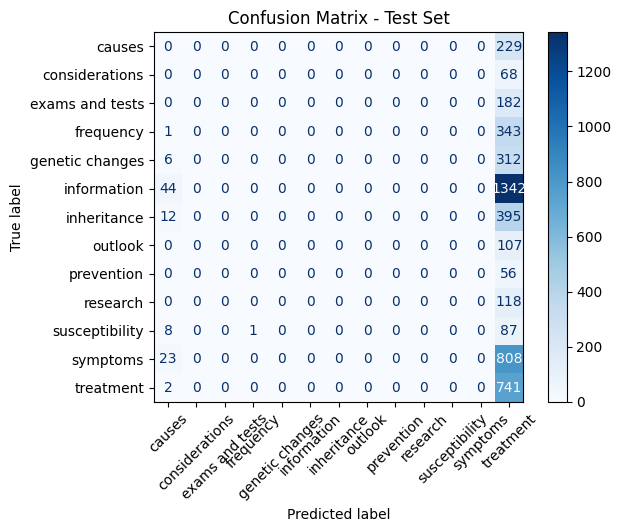

In [38]:
# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Display the confusion matrix for the test set
plt.figure(figsize=(30, 30))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)
test_disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.show()